In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from numba import njit


class IsingSimulator:
    """Numba-accelerated 2D Ising model Monte Carlo simulator."""

    def __init__(self, batch_size=1, system_size=16, spin_config=None, J=1.0, T=2.0, h=0.0):
        self.batch_size = batch_size
        self.system_size = system_size
        self.J = J  # coupling constant
        self.T = T  # temperature (k_B=1)
        self.h = h  # external field (Ising convention)
        self.reset(spin_config)

    @property
    def magnetization(self):
        """(mean, std) over batches. mean = batch mean of per-config magnetization; std for error bars."""
        m_per_batch = self.spin_config.astype(np.float64).mean(axis=(1, 2))
        return float(m_per_batch.mean()), float(m_per_batch.std(ddof=1)) if len(m_per_batch) > 1 else 0.0

    def reset(self, spin_config=None):
        if spin_config is None:
            self.spin_config = 2 * np.random.randint(2, size=(self.batch_size, self.system_size, self.system_size)) - 1
        else:
            if hasattr(spin_config, 'numpy'):
                spin_config = spin_config.numpy()
            self.batch_size = spin_config.shape[0]
            self.system_size = spin_config.shape[1]
            self.spin_config = np.asarray(spin_config, dtype=np.int8)

    def update(self, steps=None):
        """Single-spin Metropolis update (for step-by-step teaching demo)."""
        N, L = self.batch_size, self.system_size
        if steps is None:
            steps = L * L
        s_flat = np.ascontiguousarray(self.spin_config.reshape(N, -1), dtype=np.int8)
        self._update_kernel(s_flat, L, self.J, self.T, self.h, steps)
        self.spin_config = s_flat.reshape(N, L, L)

    def equilibrate(self, sweeps=100):
        """Checkerboard Gibbs update for fast equilibration. Use for hysteresis/magnetization curves."""
        L = self.system_size
        s = np.ascontiguousarray(self.spin_config, dtype=np.int8)
        beta = 1.0 / self.T
        mask = (np.add.outer(np.arange(L), np.arange(L)) % 2 == 0)
        masks = [mask, ~mask]  # even and odd sublattices
        for _ in range(sweeps):
            for mask in masks:
                sum_n = np.roll(s, 1, axis=1) + np.roll(s, -1, axis=1) + np.roll(s, 1, axis=2) + np.roll(s, -1, axis=2)
                H = self.J * sum_n.astype(np.float64) + self.h
                P_up = 1.0 / (1.0 + np.exp(-2.0 * beta * H))
                u = np.random.random(s.shape)
                new_spin = (2 * (u < P_up).astype(np.int8) - 1)
                s[:, mask] = new_spin[:, mask]
        self.spin_config = s

    def redraw(self, batch_idx=0):
        """Update display (in-place with ipympl)."""
        if not hasattr(self, '_fig') or self._fig is None:
            self._fig, self._ax = plt.subplots(figsize=(3.2, 2.4))
            self._im = self._draw_spin_config(self._fig, self._ax, batch_idx)
            self._fig.canvas.header_visible = False
            self._fig.canvas.toolbar_visible = False
            self._fig.canvas.footer_visible = False
        else:
            self._im.set_data((1 - self.spin_config[batch_idx]) / 2)
        self._fig.canvas.draw_idle()

    def _draw_spin_config(self, fig, ax, batch_idx=0):
        """Draw spin config with common styling. Returns the AxesImage for in-place updates."""
        data = (1 - self.spin_config[batch_idx]) / 2  # -1→black, +1→white
        im = ax.imshow(data, cmap='binary', vmin=0, vmax=1)
        ax.set_xticks([])
        ax.set_yticks([])
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1.5)
        fig.suptitle('Spin configuration', fontsize=10)
        fig.text(0.5, 0.02, 'Black: spin ↓, White: spin ↑', ha='center', fontsize=9)
        fig.subplots_adjust(left=0, right=1, top=0.9, bottom=0.1)
        return im

    @staticmethod
    @njit
    def _update_kernel(s_flat, L, J, T, h, steps):
        """Compiled MC update. s_flat: (N, L*L) int8 spin config, modified in place."""
        N, n_sites = s_flat.shape[0], L * L
        for _ in range(steps):
            for b in range(N):
                i = np.random.randint(0, n_sites)
                i1, i2 = i // L, i % L
                il = ((i1 - 1) % L) * L + i2
                ir = ((i1 + 1) % L) * L + i2
                ib = i1 * L + (i2 - 1) % L
                it = i1 * L + (i2 + 1) % L
                s_i = s_flat[b, i]
                sum_n = s_flat[b, il] + s_flat[b, ir] + s_flat[b, ib] + s_flat[b, it]
                dE = 2.0 * J * s_i * sum_n + 2.0 * h * s_i
                if np.random.random() <= min(1.0, math.exp(-dE / T)):
                    s_flat[b, i] = -s_i


In [2]:
get_ipython().run_line_magic('matplotlib', 'widget')
import matplotlib.pyplot as plt
from ipywidgets import Play, Button, ToggleButton, FloatSlider, VBox, HBox, Layout
from IPython.display import display

plt.close('all')
plt.ioff()

sim = IsingSimulator(batch_size=1, system_size=64, T=2.0, h=0.0)

sim.redraw()
canvas = sim._fig.canvas
canvas.layout = Layout(margin='0', padding='0')

def on_play_tick(change):
    if change['new'] == 0:
        return
    sim.update()
    sim.redraw()

def on_play_pause_toggle(change):
    play.playing = change['new']
    play_pause_btn.icon = 'pause' if change['new'] else 'play'
    play_pause_btn.description = 'Pause' if change['new'] else 'Play'

def on_refresh_click(b):
    sim.reset()
    sim.redraw()

def on_T_change(change):
    sim.T = change['new']

def on_B_change(change):
    sim.h = change['new']  # slider shows B for students; simulator uses h (Ising convention)

# Hidden Play widget – must be in widget tree for observe to fire; controlled by play_pause_btn
play = Play(value=0, min=0, max=999999999, step=1, interval=50., show_repeat=False)
play.layout = Layout(display='none')
play.observe(on_play_tick, names='value')

# Control column: T, B, play/pause, refresh (top to bottom)
T_slider = FloatSlider(value=2.0, min=0.5, max=4.0, step=0.01, description='T:', style={'description_width': '20px'})
B_slider = FloatSlider(value=0.0, min=-2.0, max=2.0, step=0.01, description='B:', style={'description_width': '20px'})
T_slider.observe(on_T_change, names='value')
B_slider.observe(on_B_change, names='value')

play_pause_btn = ToggleButton(value=False, icon='play', description='Play')
play_pause_btn.observe(on_play_pause_toggle, names='value')

refresh_btn = Button(icon='refresh', description='Refresh')
refresh_btn.on_click(on_refresh_click)

# Row: [spin config image | control column]; play in tree (hidden)
controls_col = VBox([play, T_slider, B_slider, play_pause_btn, refresh_btn], layout=Layout(align_items='flex-start', flex='0 0 auto'))
main_hbox = HBox([canvas, controls_col], layout=Layout(gap='0px', padding='0px', align_items='flex-start', justify_content='flex-start'))
wrapper = VBox([main_hbox], layout=Layout(align_items='flex-start', width='fit-content'))
display(wrapper)
plt.ion();

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import FloatSlider, VBox, Layout
from IPython.display import display
import threading

# Hysteresis parameters
B_MIN, B_MAX = -2.0, 2.0
N_STEPS = 21
BATCH_SIZE, L = 16, 32
EQUIL_SWEEPS = 10
DEBOUNCE_MS = 200

# Build B sequence: 3 cycles, -2→2, 2→-2, ...
up = np.linspace(B_MIN, B_MAX, N_STEPS)
down = np.linspace(B_MAX, B_MIN, N_STEPS)
B_values = np.concatenate([up, down[1:]])

# Figure for M vs B (ioff to avoid double display below widget)
plt.ioff()
fig, ax = plt.subplots(figsize=(4.5, 3.5))
fig.canvas.header_visible = False
fig.canvas.toolbar_visible = False
fig.canvas.footer_visible = False
fig.subplots_adjust(left=0.18, bottom=0.15, right=0.95, top=0.92)
def setup_hysteresis_axes(ax):
    """Add B/M labels and zero grid lines for hysteresis plot."""
    ax.set_xlabel('B')
    ax.set_ylabel('M')
    ax.axhline(0, color='gray', ls='--', alpha=0.5)
    ax.axvline(0, color='gray', ls='--', alpha=0.5)
setup_hysteresis_axes(ax)

_debounce_timer = None

def run_hysteresis(T):
    sim = IsingSimulator(batch_size=BATCH_SIZE, system_size=L, T=T, h=0.0)
    B_list, M_list, M_err_list = [], [], []
    for b in B_values:
        sim.h = b
        sim.T = T
        sim.equilibrate(sweeps=EQUIL_SWEEPS)
        m, m_std = sim.magnetization
        B_list.append(b)
        M_list.append(m)
        M_err_list.append(m_std)
    ax.clear()
    setup_hysteresis_axes(ax)
    ax.errorbar(B_list, M_list, yerr=M_err_list, fmt='o-', capsize=2, markersize=4)
    ax.set_title(f'Hysteresis (T={T:.2f})')
    fig.canvas.draw_idle()

def on_T_change(change):
    global _debounce_timer
    if _debounce_timer is not None:
        _debounce_timer.cancel()
    def do_run():
        run_hysteresis(change['new'])
    _debounce_timer = threading.Timer(DEBOUNCE_MS / 1000.0, do_run)
    _debounce_timer.start()

T_slider = FloatSlider(value=2.0, min=0.5, max=4.0, step=0.01, description='T:', style={'description_width': '20px'})
T_slider.observe(on_T_change, names='value')

# Initial run
run_hysteresis(T_slider.value)

wrapper = VBox([T_slider, fig.canvas], layout=Layout(align_items='flex-start', flex='0 0 auto'))
display(wrapper)
plt.ion();

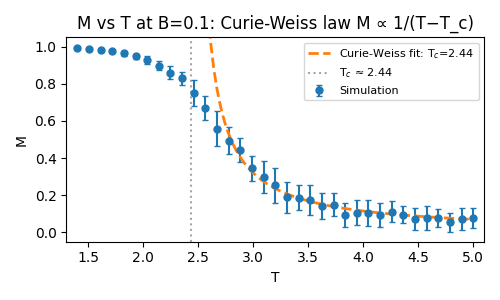

In [20]:
# M vs T at fixed B=0.1: Curie-Weiss law M ∝ 1/(T - T_c) above T_c
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

B_FIXED = 0.1
T_HIGH, T_LOW = 5.0, 1.4
N_T = 35
BATCH_SIZE, L = 32, 32
EQUIL_SWEEPS = 50

# Scan from high T toward low T
T_values = np.linspace(T_HIGH, T_LOW, N_T)
sim = IsingSimulator(batch_size=BATCH_SIZE, system_size=L, T=T_HIGH, h=B_FIXED)
M_list, M_err_list = [], []
for T in T_values:
    sim.T = T
    sim.h = B_FIXED
    sim.equilibrate(sweeps=EQUIL_SWEEPS)
    m, m_std = sim.magnetization
    M_list.append(m)
    M_err_list.append(m_std)

M_values = np.array(M_list)
M_err = np.array(M_err_list)

# Curie-Weiss: M = C / (T - T_c) for T > T_c (paramagnetic phase)
def curie_weiss(T, C, Tc):
    return C / (T - Tc)

# Fit only high-T points (well above T_c ≈ 2.27)
mask_fit = T_values > 2.7
T_fit = T_values[mask_fit]
M_fit = M_values[mask_fit]
# Weight by inverse uncertainty (avoid div by zero)
sigma_fit = np.maximum(M_err[mask_fit], 1e-6)
p0 = (0.5, 2.27)  # initial C, T_c
bounds = ([0, 1.5], [np.inf, 2.5])  # C>0, T_c in [1.5, 2.5]
popt, pcov = curve_fit(curie_weiss, T_fit, M_fit, p0=p0, bounds=bounds, sigma=sigma_fit, absolute_sigma=False)
C_fit, Tc_fit = popt

# Plot
fig, ax = plt.subplots(figsize=(5, 3))
fig.canvas.header_visible = False
ax.set_title('M vs T at B=0.1: Curie-Weiss law M ∝ 1/(T−T_c)')
ax.errorbar(T_values, M_values, yerr=M_err, fmt='o', capsize=2, markersize=5, label='Simulation')
T_smooth = np.linspace(1.01*Tc_fit, T_HIGH, 100)
ax.plot(T_smooth, curie_weiss(T_smooth, *popt), '--', color='C1', lw=2,
        label=f'Curie-Weiss fit: T$_c$={Tc_fit:.2f}')
ax.axvline(Tc_fit, color='gray', ls=':', alpha=0.7, label=f'T$_c$ ≈ {Tc_fit:.2f}')
ax.set_xlabel('T')
ax.set_ylabel('M')
ax.legend(fontsize=8)
ax.set_xlim(T_LOW - 0.1, T_HIGH + 0.1)
ax.set_ylim(-0.05, 1.05)
fig.tight_layout()
plt.show()